# TRT Haber Scraper



In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

categories = {
    'spor': 'https://www.trthaber.com/haber/spor/',
    'saglik': 'https://www.trthaber.com/haber/saglik/',
    'teknoloji': 'https://www.trthaber.com/haber/bilim-teknoloji/',
    'ekonomi': 'https://www.trthaber.com/haber/ekonomi/',
    'eğitim': 'https://www.trthaber.com/haber/egitim/',
    'sanat':'https://www.trthaber.com/haber/kultur-sanat/',

}

articles = []
max_articles_per_category = 20
headers = {'User-Agent': 'Mozilla/5.0'}

for kategori, base_url in categories.items():
    print(f"\n'{kategori}' kategorisi için haberler toplanıyor...")
    collected = 0
    page = 1
    max_pages = 7  # en fazla 7 sayfa gez

    while collected < max_articles_per_category and page <= max_pages:
        url = base_url + f"sayfa-{page}.html" if page > 1 else base_url
        resp = requests.get(url, headers=headers)
        soup = BeautifulSoup(resp.content, 'html.parser')

        news_links = soup.select("div.title > a")
        if not news_links:
            print(f"[!] Sayfa {page} için haber bağlantısı bulunamadı.")
            break

        for link_tag in news_links:
            title = link_tag.get_text(strip=True)
            link = link_tag.get('href')
            if not link.startswith("http"):
                link = "https://www.trthaber.com" + link

            try:
                detail_resp = requests.get(link, headers=headers)
                detail_soup = BeautifulSoup(detail_resp.content, 'html.parser')

                # Ana içerik seçici
                paragraphs = detail_soup.select("div.news-content > p")
                if not paragraphs:
                    # Alternatif seçici denemesi
                    paragraphs = detail_soup.select("div.text > p")

                content = " ".join(p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True))

                if len(content) > 80:  # alt sınırı biraz düşürdük
                    articles.append({
                        "kategori": kategori,
                        "baslik": title,
                        "link": link,
                        "icerik": content
                    })
                    collected += 1
                    print(f"✅ {collected}. haber çekildi: {title[:50]}...")
                    if collected >= max_articles_per_category:
                        break
                else:
                    print(f"⏭ İçerik yetersiz: {title[:40]}")

                time.sleep(0.5)
            except Exception as e:
                print(f"[Hata] {link} - {e}")
                continue

        page += 1

# CSV'ye yaz
df = pd.DataFrame(articles)
df.to_csv("trt_haber_kategori.csv", index=False, encoding="utf-8-sig")
print("\n✅ İşlem tamamlandı. 'trt_haber_kategorik.csv' dosyası oluşturuldu.")



'spor' kategorisi için haberler toplanıyor...
✅ 1. haber çekildi: MHP Genel Başkanı Bahçeli, Galatasaray’ın şampiyon...
✅ 2. haber çekildi: Cumhurbaşkanlığı 6. Uluslararası Yat Yarışları'nın...
✅ 3. haber çekildi: Engellilere umut olan engelli basketbolcu: Oğuzhan...
✅ 4. haber çekildi: Ziraat Türkiye Kupası'nın sahibi Galatasaray oldu...
✅ 5. haber çekildi: "Yaklaşık 862 yurdumuzda gençlerimize barınma hizm...
✅ 6. haber çekildi: Fenerbahçe Beko, THY Avrupa Ligi'nde dörtlü finale...
✅ 7. haber çekildi: İsviçreli eskrimciler, Avrupa Şampiyonası'nda İsra...
✅ 8. haber çekildi: Cumhurbaşkanlığı Türkiye Bisiklet Turu'nun ilk eta...
✅ 9. haber çekildi: Ziraat Türkiye Kupası finali, Gaziantep Stadı'nda ...
✅ 10. haber çekildi: UEFA İstanbul Ofisi açıldı...
✅ 11. haber çekildi: Kocaelispor, 16 yıl sonra Süper Lig'de...
✅ 12. haber çekildi: Bakan Bak: Etnospor, gençlerin geleneksel sporlara...
✅ 13. haber çekildi: Türkiye Kupası finali Eskişehir'de oynanacak...
✅ 14. haber çekildi: Milli gür

# NTV Haber Scraper

In [3]:


categories = {
    'spor': 'https://www.ntv.com.tr/spor',
    'saglik': 'https://www.ntv.com.tr/saglik',
    'teknoloji': 'https://www.ntv.com.tr/teknoloji',
    'ekonomi': 'https://www.ntv.com.tr/ekonomi',
    'eğitim': 'https://www.ntv.com.tr/egitim',
    'sanat':'https://www.ntv.com.tr/sanat',
}

articles = []
max_articles_per_category = 20
headers = {'User-Agent': 'Mozilla/5.0'}

for kategori, base_url in categories.items():
    print(f"\n'{kategori}' kategorisi için haberler toplanıyor...")
    collected = 0
    page = 1
    seen_links = set()

    while collected < max_articles_per_category and page <= 5:
        url = base_url + f"?page={page}"
        resp = requests.get(url, headers=headers)
        soup = BeautifulSoup(resp.content, 'html.parser')

        link_tags = soup.select("div.card-text-wrapper > h3 > a")
        if not link_tags:
            print(f"[!] Sayfa {page} için bağlantı bulunamadı.")
            break

        for tag in link_tags:
            link = tag.get("href")
            if not link:
                continue
            if not link.startswith("http"):
                link = "https://www.ntv.com.tr" + link
            if link in seen_links:
                continue
            seen_links.add(link)

            try:
                detail_resp = requests.get(link, headers=headers)
                detail_soup = BeautifulSoup(detail_resp.content, 'html.parser')
                title_tag = detail_soup.find("h1")
                title = title_tag.get_text(strip=True) if title_tag else "Başlık yok"
                paragraphs = detail_soup.select("div.content-news-tag-selector > p")
                content = " ".join(p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True))

                if len(content) > 100:
                    articles.append({
                        "kategori": kategori,
                        "baslik": title,
                        "link": link,
                        "icerik": content
                    })
                    collected += 1
                    print(f"✅ {collected}. haber çekildi: {title[:50]}...")
                    if collected >= max_articles_per_category:
                        break
                else:
                    print(f"⏭ İçerik yetersiz: {link}")
                time.sleep(0.5)
            except Exception as e:
                print(f"[Hata] {link} - {e}")
                continue

        page += 1

df = pd.DataFrame(articles)
df.to_csv("ntv_haber_kategorik2.csv", index=False, encoding="utf-8-sig")
print("\n✅ İşlem tamamlandı. 'ntv_haber_kategorik.csv' dosyası oluşturuldu.")


'spor' kategorisi için haberler toplanıyor...
⏭ İçerik yetersiz: https://www.ntv.com.tr/galeri/sporskor/galatasaray-yenikapi-sampiyonluk-kutlamasi-saat-kacta-hangi-kanalda-galatasaray-kutlama-programi,AMPfFoYVjkK-aqpW86xyZA
⏭ İçerik yetersiz: https://www.ntv.com.tr/galeri/sporskor/fenerbahce-transferde-rotayi-premier-lige-cevirdi-25-mayis-2025-spor-mansetleri,WFlbP0DUSEO8bu1LULcnIw
✅ 1. haber çekildi: Köprüler sarı kırmızılı renklerle aydınlatıldı...
✅ 2. haber çekildi: Stuttgart, Almanya Kupası’nı müzesine götürdü...
✅ 3. haber çekildi: Ancelotti ve Modric'ten Real Madrid'e veda...
✅ 4. haber çekildi: Salah, Premier Lig'de "sezonun oyuncusu" seçildi...
✅ 5. haber çekildi: Okan Buruk: Bazen sahanın içerisinde oynadığınız f...
✅ 6. haber çekildi: Galatasaray otobüsüne taşlı saldırı...
✅ 7. haber çekildi: Belediyeler, Fenerbahçe Beko'nun finalini kamusal ...
✅ 8. haber çekildi: 90+5'te gelen gol, Sunderland'i yıllar sonra Premi...
⏭ İçerik yetersiz: https://www.ntv.com.tr/galeri/sporsko

#Haber Türk Scraper

In [4]:

categories = {
    'spor': 'https://www.haberturk.com/spor',
    'saglik': 'https://www.haberturk.com/saglik',
    'teknoloji': 'https://www.haberturk.com/ekonomi/teknoloji',
    'ekonomi': 'https://www.haberturk.com/ekonomi',
    'eğitim': 'https://www.haberturk.com/gundem/egitim',
    'sanat':'https://www.haberturk.com/kultur-sanat',
}

articles = []
max_articles_per_category = 40
headers = {'User-Agent': 'Mozilla/5.0'}

for kategori, base_url in categories.items():
    print(f"\n📥 '{kategori}' kategorisi için haberler toplanıyor...")
    collected = 0
    page = 1
    seen_links = set()

    while collected < max_articles_per_category and page <= 5:
        url = f"{base_url}?page={page}"
        resp = requests.get(url, headers=headers)
        soup = BeautifulSoup(resp.content, 'html.parser')

        link_tags = soup.select("div.w-full > a")
        if not link_tags:
            print(f"[!] Sayfa {page} için bağlantı bulunamadı.")
            break

        for tag in link_tags:
            link = tag.get("href")
            if not link:
                continue
            if not link.startswith("http"):
                link = "https://www.haberturk.com" + link
            if link in seen_links:
                continue
            seen_links.add(link)

            try:
                detail_resp = requests.get(link, headers=headers)
                detail_soup = BeautifulSoup(detail_resp.content, 'html.parser')

                title_tag = detail_soup.find("h1")
                title = title_tag.get_text(strip=True) if title_tag else "Başlık yok"

                paragraphs = detail_soup.select("div.cms-container > p")
                content = " ".join(p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True))

                if len(content) > 100:
                    articles.append({
                        "kategori": kategori,
                        "baslik": title,
                        "link": link,
                        "icerik": content
                    })
                    collected += 1
                    print(f"✅ {collected}. haber çekildi: {title[:50]}...")
                    if collected >= max_articles_per_category:
                        break
                else:
                    print(f"⏭ İçerik yetersiz: {link}")

                time.sleep(0.5)

            except Exception as e:
                print(f"[Hata] {link} - {e}")
                continue

        page += 1

df = pd.DataFrame(articles)
df.to_csv("haberturk_haber_kategorik.csv", index=False, encoding="utf-8-sig")
print("\n✅ İşlem tamamlandı. 'haberturk_haber_kategorik.csv' dosyası oluşturuldu.")



📥 'spor' kategorisi için haberler toplanıyor...
✅ 1. haber çekildi: İşte Beşiktaş- Rizespor maçının VAR'ı!...
✅ 2. haber çekildi: Minnesota Timberwolves seride öne geçti!...
✅ 3. haber çekildi: Milan taraftarları yönetimi protesto etti...
✅ 4. haber çekildi: PSG: 3 - Reims: 0 | MAÇ SONUCU...
✅ 5. haber çekildi: İtalya: 3 - Türkiye: 2 | MAÇ SONUCU...
✅ 6. haber çekildi: Real Madrid: 2 - Real Sociedad: 0 | MAÇ SONUCU...
✅ 7. haber çekildi: Formula 1 Monaco GP'de pole pozisyonu Lando Norris...
✅ 8. haber çekildi: Premier Lig'de sezonun futbolcusu Muhammed Salah s...
✅ 9. haber çekildi: Coutinho röportaj verirken silahlı saldırı çıktı...
✅ 10. haber çekildi: Fenerbahçe Beko, Avrupa'da ikinci şampiyonluk için...
✅ 11. haber çekildi: Galatasaray Yenikapı'da kupasına kavuşuyor!...
✅ 12. haber çekildi: Fenerbahçe Beko kupa için parkeye çıkacak!...
✅ 13. haber çekildi: Spor yazarları Göztepe-Galatasaray maçını değerlen...
✅ 14. haber çekildi: Göztepe: 0 - Galatasaray: 2 | MAÇ SONUCU...
✅ 15. h

# Haber Verisi Birleştirici ve Temizleyici

In [5]:
import pandas as pd

# CSV'leri oku
ntv = pd.read_csv("ntv_haber_kategorik2.csv")
haberturk = pd.read_csv("haberturk_haber_kategorik.csv")
trthaber = pd.read_csv("trt_haber_kategori.csv")  # varsa

# Hepsini birleştir (kategori sütunları korunur)
df = pd.concat([ntv, haberturk, trthaber], ignore_index=True)

# Gereksiz veya boş haberleri çıkar
df.dropna(subset=["baslik", "icerik", "kategori"], inplace=True)

# Aynı başlıkları sil (kaynaktan bağımsız tekrarları önlemek için)
df.drop_duplicates(subset=["baslik"], inplace=True)

# Kategorilere göre haber sayısını göster
print(df["kategori"].value_counts())

# Birleştirilmiş dosyayı kaydet
df.to_csv("haber_dataset_birlesik1.csv", index=False, encoding="utf-8-sig")

print(f"✅ Birleşik veri hazır. Toplam {len(df)} haber kaydedildi.")


kategori
spor         75
teknoloji    74
sanat        74
saglik       73
ekonomi      72
eğitim       69
Name: count, dtype: int64
✅ Birleşik veri hazır. Toplam 437 haber kaydedildi.


# Kategorilere Göre Haber Dağılımı Grafiği


<ipython-input-6-c67337bd1233>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='kategori', palette='Set2')


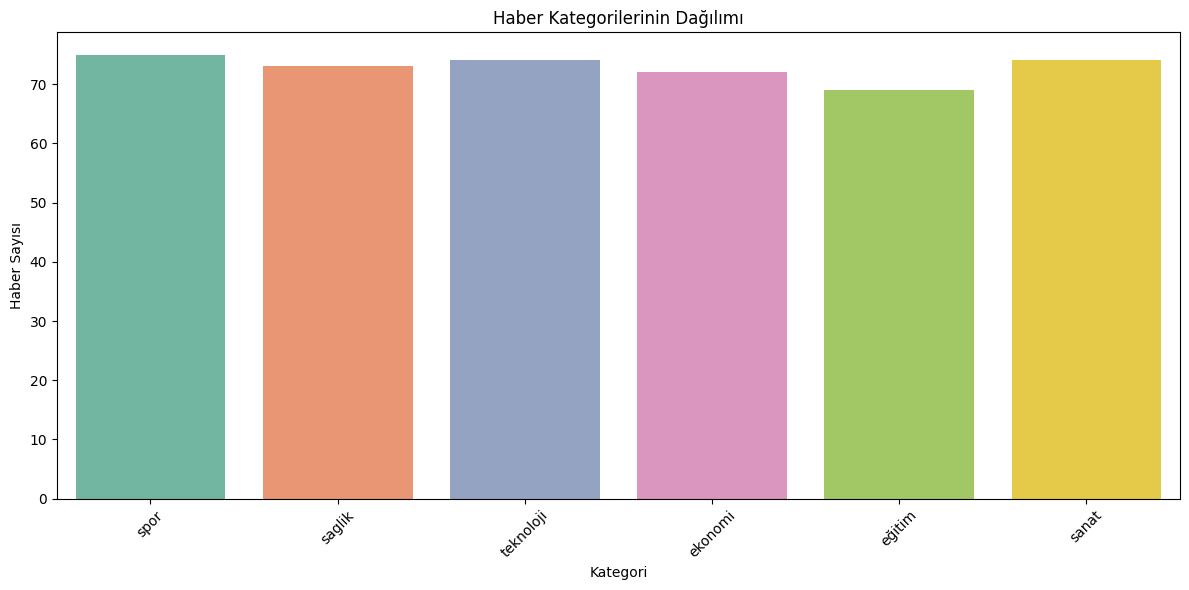

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='kategori', palette='Set2')
plt.title("Haber Kategorilerinin Dağılımı")
plt.xlabel("Kategori")
plt.ylabel("Haber Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Haber Metinlerini Temizleme ve Stopword Kaldırma


In [7]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

# nltk ögelerini indir
nltk.download('punkt')
nltk.download('stopwords')

# Veri setini yükle
df = pd.read_csv("haber_dataset_birlesik1.csv")

# Stopword listesi (Türkçe + İngilizce)
stop_words_tr = set(stopwords.words('turkish'))
stop_words_en = set(stopwords.words('english'))
stop_words = stop_words_tr.union(stop_words_en)

def temizle_metni(metin):
    metin = str(metin).lower()                             # Küçük harfe çevir
    metin = re.sub(r'http\S+', '', metin)                  # Linkleri sil
    metin = re.sub(r'\d+', '', metin)                      # Sayıları sil
    metin = re.sub(r'[^\w\s]', '', metin)                  # Noktalama işaretleri sil
    kelimeler = metin.split()
    kelimeler = [k for k in kelimeler if k not in stop_words]  # Stopword temizliği
    return " ".join(kelimeler)

# Tüm içerikleri temizle
df["temiz_icerik"] = df["icerik"].apply(temizle_metni)

# Örnek çıktı
print(df[["kategori", "baslik", "temiz_icerik"]].head(3))

# Kaydet
df.to_csv("haber_dataset_temiz.csv", index=False, encoding="utf-8-sig")
print("\n✅ Temizlenmiş veri kaydedildi: haber_dataset_temiz.csv")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  kategori                                          baslik  \
0     spor  Köprüler sarı kırmızılı renklerle aydınlatıldı   
1     spor   Stuttgart, Almanya Kupası’nı müzesine götürdü   
2     spor      Ancelotti ve Modric'ten Real Madrid'e veda   

                                        temiz_icerik  
0  galatasarayın trendyol süper ligin sezonunu şa...  
1  almanyakupası finalinde arminia bielefeld stut...  
2  ispanya futbolliginde laliga sezonun son maçın...  

✅ Temizlenmiş veri kaydedildi: haber_dataset_temiz.csv


In [8]:
pip install turkishstemmer


In [11]:
from TurkishStemmer import TurkishStemmer

stemmer = TurkishStemmer()




# Haber Metinlerinin Gelişmiş Temizliği ve Kök İndirgeme


In [13]:
import pandas as pd
import re
import nltk
import unicodedata
from nltk.corpus import stopwords
from TurkishStemmer import TurkishStemmer

# NLTK ögelerini indir
nltk.download('punkt')
nltk.download('stopwords')

# Türkçe kök indirgeme
stemmer = TurkishStemmer()

# Stopword listesi (Türkçe + İngilizce)
stop_words_tr = set(stopwords.words('turkish'))
stop_words_en = set(stopwords.words('english'))
stop_words = stop_words_tr.union(stop_words_en)

def temizle_metni(metin):
    if pd.isna(metin):
        return ""

    # 1. Küçük harf ve unicode normalize
    metin = str(metin).lower()
    metin = unicodedata.normalize("NFKD", metin)

    # 2. URL ve e-posta sil
    metin = re.sub(r'http\S+|www\.\S+', '', metin)
    metin = re.sub(r'\S+@\S+', '', metin)

    # 3. Sayılar ve noktalama temizliği
    metin = re.sub(r'\d+', '', metin)
    metin = re.sub(r'[^\w\s]', '', metin)

    # 4. Fazla boşluklar
    metin = re.sub(r'\s+', ' ', metin).strip()

    # 5. Kelime tokenize ve filtre
    kelimeler = metin.split()
    kelimeler = [k for k in kelimeler if k.isalpha()]
    kelimeler = [k for k in kelimeler if k not in stop_words and len(k) > 2]

    # 6. Kök indirgeme
    kelimeler = [stemmer.stem(k) for k in kelimeler]

    return " ".join(kelimeler)

# Veri setini yükle
df = pd.read_csv("haber_dataset_birlesik1.csv")

# Temizleme işlemi
df["temiz_icerik"] = df["icerik"].apply(temizle_metni)

# İlk örnekleri göster
print(df[["kategori", "baslik", "temiz_icerik"]].head(3))

# Temizlenmiş veriyi kaydet
df.to_csv("haber_dataset_temiz.csv", index=False, encoding="utf-8-sig")
print("\n✅ Temizlenmiş veri başarıyla kaydedildi: haber_dataset_temiz.csv")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  kategori                                          baslik  \
0     spor  Köprüler sarı kırmızılı renklerle aydınlatıldı   
1     spor   Stuttgart, Almanya Kupası’nı müzesine götürdü   
2     spor      Ancelotti ve Modric'ten Real Madrid'e veda   

                                        temiz_icerik  
0  galatasaray trendyol super lig sezon sampiyon ...  
1  almanyakupa finalin arminia bielefeld stuttgar...  
2  ispanya futbollig laliga sezo son macındareal ...  

✅ Temizlenmiş veri başarıyla kaydedildi: haber_dataset_temiz.csv


In [14]:
!pip install -q scikit-learn pandas nltk


In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import pickle


# TF-IDF Vektörleri ve Label Encoding


In [16]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("haber_dataset_temiz.csv")

# TF-IDF vektörleri
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # 1-gram ve 2-gram
X = vectorizer.fit_transform(df["temiz_icerik"])


# Kategori etiket kodlama
le = LabelEncoder()
y = le.fit_transform(df["kategori"])



# Eğitim ve Test Verisinin Ayrılması


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Sınıflandırma Modelleri ve Hiperparametreler


In [18]:
models_params = {
    "Naive Bayes": (
        MultinomialNB(),
        {'alpha': [0.1, 0.5, 1.0]}
    ),
    "Logistic Regression": (
        LogisticRegression(max_iter=500),
        {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
    ),
    "Linear SVM": (
        LinearSVC(max_iter=1000),
        {'C': [0.01, 0.1, 1, 10]}
    ),
    "Random Forest": (
        RandomForestClassifier(),
        {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]}
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(),
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
}


#Model Optimizasyonu ve En İyi Sonuçlar

In [19]:
best_models = {}

for name, (model, params) in models_params.items():
    print(f"\n🔎 {name} için eğitim başlıyor...")
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"✅ En iyi parametreler: {grid.best_params_}")
    print(f"📈 En iyi doğruluk: {grid.best_score_:.4f}")



🔎 Naive Bayes için eğitim başlıyor...
✅ En iyi parametreler: {'alpha': 1.0}
📈 En iyi doğruluk: 0.8769

🔎 Logistic Regression için eğitim başlıyor...
✅ En iyi parametreler: {'C': 10, 'solver': 'lbfgs'}
📈 En iyi doğruluk: 0.8883

🔎 Linear SVM için eğitim başlıyor...
✅ En iyi parametreler: {'C': 0.1}
📈 En iyi doğruluk: 0.8883

🔎 Random Forest için eğitim başlıyor...
✅ En iyi parametreler: {'max_depth': None, 'n_estimators': 100}
📈 En iyi doğruluk: 0.8025

🔎 Gradient Boosting için eğitim başlıyor...
✅ En iyi parametreler: {'learning_rate': 0.1, 'n_estimators': 100}
📈 En iyi doğruluk: 0.7424


# Modellerin Test Seti Üzerindeki Performans Değerlendirmesi ve Doğruluk Analizi

In [20]:
for name, model in best_models.items():
    print(f"\n{name} Test Sonuçları:")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print(f"🎯 Doğruluk Oranı: {accuracy_score(y_test, y_pred):.4f}")



Naive Bayes Test Sonuçları:
              precision    recall  f1-score   support

     ekonomi       0.71      0.86      0.77        14
      eğitim       1.00      0.93      0.96        14
      saglik       0.94      1.00      0.97        15
       sanat       0.94      1.00      0.97        15
        spor       1.00      1.00      1.00        15
   teknoloji       0.91      0.67      0.77        15

    accuracy                           0.91        88
   macro avg       0.91      0.91      0.91        88
weighted avg       0.92      0.91      0.91        88

🎯 Doğruluk Oranı: 0.9091

Logistic Regression Test Sonuçları:
              precision    recall  f1-score   support

     ekonomi       0.72      0.93      0.81        14
      eğitim       1.00      0.93      0.96        14
      saglik       0.94      1.00      0.97        15
       sanat       0.94      1.00      0.97        15
        spor       1.00      1.00      1.00        15
   teknoloji       1.00      0.67      0.

# En İyi Modelin Belirlenmesi ve Doğruluk Skoru

In [21]:
best_model_name = None
best_accuracy = 0

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    if acc > best_accuracy:
        best_accuracy = acc
        best_model_name = name

print(f"\n🏆 En iyi model: {best_model_name} - Doğruluk: {best_accuracy:.4f}")
best_model = best_models[best_model_name]



🏆 En iyi model: Logistic Regression - Doğruluk: 0.9205


# Model, Vectorizer ve Label Encoder'ın Kaydedilmesi

In [22]:
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ Model, vectorizer ve label encoder başarıyla kaydedildi.")


✅ Model, vectorizer ve label encoder başarıyla kaydedildi.


# Kaydedilen Model ile Yeni Haberlerin Kategorize Edilmesi

In [28]:
# Kaydedilen dosyaları yükle
with open("best_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)
# Yeni haber örnekleri
yeni_haberler = [
    "Ronaldo'nun gelecek sezon Beşiktaş'a transfer olacağı konuşuluyor.",
    "Zeki Müren’in eserleri, sanat dünyasında paha biçilmez olarak görülüyor.",
    "Uzmanlar, yaz aylarında güneş çarpmasına karşı bol su tüketilmesini öneriyor.",
    "Yerli girişim, yapay zeka destekli tarım robotu üretti.",
    "Merkez Bankası, politika faiz oranını 25 baz puan artırdı.",
    "Üniversite sınavına giren aday sayısı bu yıl rekor seviyeye ulaştı.",

]

# Vektöre çevir ve tahmin et
X_yeni = vectorizer.transform(yeni_haberler)
tahminler = model.predict(X_yeni)
tahmin_kategoriler = le.inverse_transform(tahminler)

# Sonuçları yazdır
for haber, kategori in zip(yeni_haberler, tahmin_kategoriler):
    print(f"\nHaber: {haber}\nTahmin edilen kategori: {kategori}")



Haber: Ronaldo'nun gelecek sezon Beşiktaş'a transfer olacağı konuşuluyor.
Tahmin edilen kategori: spor

Haber: Zeki Müren’in eserleri, sanat dünyasında paha biçilmez olarak görülüyor.
Tahmin edilen kategori: sanat

Haber: Uzmanlar, yaz aylarında güneş çarpmasına karşı bol su tüketilmesini öneriyor.
Tahmin edilen kategori: saglik

Haber: Yerli girişim, yapay zeka destekli tarım robotu üretti.
Tahmin edilen kategori: teknoloji

Haber: Merkez Bankası, politika faiz oranını 25 baz puan artırdı.
Tahmin edilen kategori: ekonomi

Haber: Üniversite sınavına giren aday sayısı bu yıl rekor seviyeye ulaştı.
Tahmin edilen kategori: eğitim
